## Overview

This is a simple tutorial showing how to use the code provided to train a RNN model learning initial CV reduplication patterns. Data is taken from https://github.com/MaxAndrewNelson/Neural-Reduplication/tree/master/data.

**Note**: 

- Definition: Initial CV reduplication is a common reduplication pattern where initial CV in a word gets reduplicated, so hypothecially, "ba" --> "baba", "baba" --> "bababa" (not "babababa" because the later "ba" is not initial), and "bba" --> "bba" (not "bbaba" because "ba" is not initial). 
- The data used for training and evaluation **only consists of positive examples**. The reduplicated strings are already tokenized by myself. 
- I have also done simulation with pesudo initial CV reduplication data which, however, on one hand has much less examples (just to test the sample complexity needed to train a robust model), and on the other hand, also consists of negative examples.

## Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from scripts.visualization import plot_training_log
from scripts.utils import read_data, create_dir, read_json, save_dict_as_json
from scripts.dataloader import get_text_encoder_decoder, customize_dataloader_func
from scripts.pytorch_utils import get_model, train_and_evaluate, evaluate, customize_predictor, predict_next

## For reproducibility (if needed)

- **Noes**: If you results differ, try to run the notebook for more than one times. The notebook takes less a minute to run for a 2020 Mac Pro laptop. 

In [2]:
import random 
import numpy as np

seed = 21567
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Get data set up

### Import the data and tokenize the output sequences 

- Since RNNs can only produce same number of input tokens as the outputs, it is important to align the input and output sequences. Here, it happens that the output sequence is strictly longer than the input sequence, so we need to only tokenize the output sequences. 
- The input sequence needs not to be tokenized because every token in it is exactly an character. In Python, string is also iterable. It is also Okay to tokenize the input sequence by using `list` so that it is easier to see the alignment between the input and output sequences.

In [3]:
train = read_data("data/init_cv_red_more_real/train.txt")
dev = read_data("data/init_cv_red_more_real/dev.txt")
test = read_data("data/init_cv_red_more_real/test_with_answers.txt")
train[:10]

[['wedo', 'w-ewe-d-o'],
 ['bigxij', 'b-ibi-g-x-i-j'],
 ['kocmiveqeciw', 'k-oko-c-m-i-v-e-q-e-c-i-w'],
 ['qumyw', 'q-uqu-m-y-w'],
 ['sylys', 's-ysy-l-y-s'],
 ['zyqafij', 'z-yzy-q-a-f-i-j'],
 ['zypwabi', 'z-yzy-p-w-a-b-i'],
 ['taby', 't-ata-b-y'],
 ['jarnumjy', 'j-aja-r-n-u-m-j-y'],
 ['livkuwpa', 'l-ili-v-k-u-w-p-a']]

In [4]:
train = [[t1, t2.split("-")] for (t1, t2) in train]
dev = [[t1, t2.split("-")] for (t1, t2) in dev]
test = [[t1, t2.split("-")] for (t1, t2) in test]

train[:10]

[['wedo', ['w', 'ewe', 'd', 'o']],
 ['bigxij', ['b', 'ibi', 'g', 'x', 'i', 'j']],
 ['kocmiveqeciw',
  ['k', 'oko', 'c', 'm', 'i', 'v', 'e', 'q', 'e', 'c', 'i', 'w']],
 ['qumyw', ['q', 'uqu', 'm', 'y', 'w']],
 ['sylys', ['s', 'ysy', 'l', 'y', 's']],
 ['zyqafij', ['z', 'yzy', 'q', 'a', 'f', 'i', 'j']],
 ['zypwabi', ['z', 'yzy', 'p', 'w', 'a', 'b', 'i']],
 ['taby', ['t', 'ata', 'b', 'y']],
 ['jarnumjy', ['j', 'aja', 'r', 'n', 'u', 'm', 'j', 'y']],
 ['livkuwpa', ['l', 'ili', 'v', 'k', 'u', 'w', 'p', 'a']]]

### Get the input and output vocabularies and the mapping functions

- `get_text_encoder_decoder` is a very simplistic function that returns two functions that can encode input tokens into a list of integers and decode encoded inputs tokens back into a list of string. You can also define one on your own if needed.

In [5]:
in_vocab = list(set([v for (text, _) in train for v in text]))
out_vocab = list(set([v for (_, text) in train for v in text]))

# add a "UNK_OR_PAD" token as both an Unkown and Padding token
in_vocab = ["UNK_OR_PAD"] + in_vocab
out_vocab = ["UNK_OR_PAD"] + out_vocab

print("Size of input vocabulary:", len(in_vocab))
print("Size of output vocabulary:", len(out_vocab))

Size of input vocabulary: 27
Size of output vocabulary: 147


In [6]:
# in_seq_decoder will not be used anyway
in_seq_encoder, _ = get_text_encoder_decoder(in_vocab)
out_seq_encoder, out_seq_decoder = get_text_encoder_decoder(out_vocab)

In [7]:
# due to different vocabulary stock, in_seq_encoder and out_seq_decoder encode differently
example_str = "abcd"

print(f"example_str '{example_str}' encoded by in_seq_encoder:", in_seq_encoder(example_str))
print(f"example_str '{example_str}' encoded by out_seq_encoder:", out_seq_encoder(example_str))

example_str 'abcd' encoded by in_seq_encoder: [24, 5, 11, 2]
example_str 'abcd' encoded by out_seq_encoder: [67, 3, 123, 1]


In [8]:
# please note that out_seq_decoder will only relate to in_seq_encoder
print(out_seq_decoder(in_seq_encoder(example_str)))
print(out_seq_decoder(out_seq_encoder(example_str)))

['l', 'oco', 'p', 'eje']
['a', 'b', 'c', 'd']


## Dataloader function

In [9]:
in_seq_encoder(["UNK_OR_PAD"]), out_seq_encoder(["UNK_OR_PAD"])

([0], [0])

In [10]:
padding_idx = 0 # see above
batch_size = 1000

dataloader_func = customize_dataloader_func(in_seq_encoder, 
                                            out_seq_encoder, 
                                            padding_idx=padding_idx, 
                                            batch_size=batch_size)

train_dl = dataloader_func(train)
dev_dl = dataloader_func(dev)
test_dl = dataloader_func(test)

## Training

**ModelConfig**:

- `bias (bool)`: whether to include bias terms during training 
- `rnn_type (str)`: SRNN (Simple RNN), LSTM, GRU
- `embd_dim (integer)`: embedding dimension
- `num_layers (integer)`: number of RNN layers.
- `hidden_size (integer)`: size of the hidden units
- `dropout_rate (float)`: 0 ~ 1(not included), dropout rate.
- `device (str)`: cpu or cuda
- `bidirectional (bool)`: whether to use bidirectional RNNs.
- `in_vocab_size (integer)`: size of the input vocabulary 
- `out_vocab_size (integer)`: size of the output vocabulary
- `reduction_method (str)`: sum or mean, ways to reduce dimensions when `bidirectional` is `True`

In [11]:
# this helps you to save the ModelConfig if you want to save the trained model and reuse it later on
ModelConfig = {"bias": True, 
               "rnn_type": "SRNN",
               "embd_dim": 32, 
               "num_layers": 1,
               "hidden_size": 32, 
               "dropout_rate": 0.0,
               "device": "cpu", 
               "bidirectional": False,
               "in_vocab_size": len(in_vocab),
               "out_vocab_size": len(out_vocab),
               "reduction_method": "sum"}

model = get_model(ModelConfig)

The model has 7,827 trainable parameters


In [12]:
# lr: learing rate; weight_decay: L2 regularization alpha 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

rnn_type = ModelConfig["rnn_type"]
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp=f"init_cv_red_{rnn_type}_model.pt", 
                         acc_threshold=0.0, # if this is set greater than 1.0, no model will be saved.
                         print_eval_freq=1, max_epoch_num=100, 
                         train_exit_acc=1.0, eval_exit_acc=1.0)

Current epoch: 1, 
training performance: {'loss': 2.858276883761088, 'full sequence accuracy': 0.0, 'first n-symbol accuracy': 0.019755555555555557, 'overlap rate': 0.5723777777777778}
evaluation performance: {'loss': 2.8475072383880615, 'full sequence accuracy': 0.0, 'first n-symbol accuracy': 0.018133333333333335, 'overlap rate': 0.5746}

Current epoch: 2, 
training performance: {'loss': 2.1524547338485718, 'full sequence accuracy': 0.0, 'first n-symbol accuracy': 0.039488888888888886, 'overlap rate': 0.5925444444444444}
evaluation performance: {'loss': 2.1343085765838623, 'full sequence accuracy': 0.0, 'first n-symbol accuracy': 0.0386, 'overlap rate': 0.5952666666666666}

Current epoch: 3, 
training performance: {'loss': 1.7074226140975952, 'full sequence accuracy': 0.0, 'first n-symbol accuracy': 0.06666666666666667, 'overlap rate': 0.674388888888889}
evaluation performance: {'loss': 1.7035753726959229, 'full sequence accuracy': 0.0, 'first n-symbol accuracy': 0.06666666666666667,

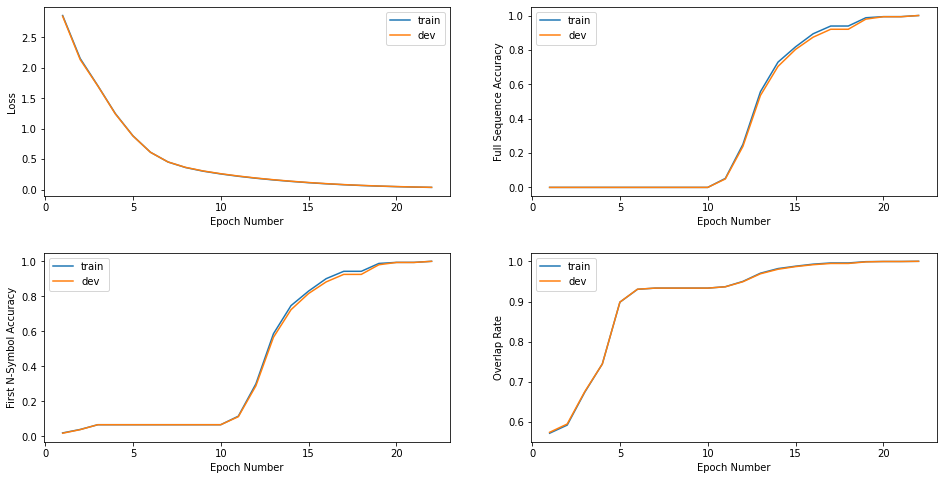

In [13]:
plot_training_log(log)

## Evaluation

- Works perfectly for the held out test set!

In [14]:
evaluate(model, test_dl, criterion)

{'loss': 0.0384137307604154,
 'full sequence accuracy': 1.0,
 'first n-symbol accuracy': 1.0,
 'overlap rate': 1.0}

## Save ModelConfig and Reuse saved model

- Suppose you want to deploy the saved model anytime you want. To do that, we also need to save the ModelConfig along with the saved trained model so that we can reuse the later with correct setups. 

In [15]:
save_dict_as_json(ModelConfig, "ModelConfig.json")

ModelConfig.json saved!


In [16]:
del ModelConfig; del model

In [17]:
saved_modelconfig_path = "ModelConfig.json"
ModelConfig = read_json(saved_modelconfig_path)
model = get_model(ModelConfig, init_method=None)

The model has 7,827 trainable parameters


In [18]:
saved_model_path = "init_cv_red_SRNN_model.pt"
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [19]:
# check the Evalutation section. Same results, meaning same model!
evaluate(model, test_dl, criterion)

{'loss': 0.0384137307604154,
 'full sequence accuracy': 1.0,
 'first n-symbol accuracy': 1.0,
 'overlap rate': 1.0}

## Deployment


In [20]:
predictor = customize_predictor(model, dataloader_func, out_seq_decoder, batch_size=1)

In [21]:
test_examples = [t1 for (t1, t2) in test[:10]]
answers = [t2 for (t1, t2) in test[:10]]
test_examples

['damdupduteq',
 'xop',
 'ravix',
 'xuppivwuv',
 'ramy',
 'sypsim',
 'noqalcogo',
 'negeh',
 'pigappitxo',
 'maqa']

In [22]:
predicted = predictor(test_examples)
predicted

[['d', 'ada', 'm', 'd', 'u', 'p', 'd', 'u', 't', 'e', 'q'],
 ['x', 'oxo', 'p'],
 ['r', 'ara', 'v', 'i', 'x'],
 ['x', 'uxu', 'p', 'p', 'i', 'v', 'w', 'u', 'v'],
 ['r', 'ara', 'm', 'y'],
 ['s', 'ysy', 'p', 's', 'i', 'm'],
 ['n', 'ono', 'q', 'a', 'l', 'c', 'o', 'g', 'o'],
 ['n', 'ene', 'g', 'e', 'h'],
 ['p', 'ipi', 'g', 'a', 'p', 'p', 'i', 't', 'x', 'o'],
 ['m', 'ama', 'q', 'a']]

In [23]:
for p, a in zip(predicted, answers):
    print(p==a)

True
True
True
True
True
True
True
True
True
True


In [24]:
# however, if you set the batch_size to be greater than 1, you will see the following
predicted = predictor(test_examples, batch_size=10)
for p in predicted:
    print(p)

['d', 'ada', 'm', 'd', 'u', 'p', 'd', 'u', 't', 'e', 'q']
['x', 'oxo', 'p', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD']
['r', 'ara', 'v', 'i', 'x', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD']
['x', 'uxu', 'p', 'p', 'i', 'v', 'w', 'u', 'v', 'UNK_OR_PAD', 'UNK_OR_PAD']
['r', 'ara', 'm', 'y', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD']
['s', 'ysy', 'p', 's', 'i', 'm', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD']
['n', 'ono', 'q', 'a', 'l', 'c', 'o', 'g', 'o', 'UNK_OR_PAD', 'UNK_OR_PAD']
['n', 'ene', 'g', 'e', 'h', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD']
['p', 'ipi', 'g', 'a', 'p', 'p', 'i', 't', 'x', 'o', 'UNK_OR_PAD']
['m', 'ama', 'q', 'a', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD', 'UNK_OR_PAD']


## State transition

In [25]:
string = "babababa"
cur_pred = predict_next(string[0], model, in_seq_encoder, out_seq_decoder, re_start=True)
print(f"Input ~ output: {string[0]} --> {cur_pred[0]}")
for char in string[1:]:
    cur_pred = predict_next(char, model, in_seq_encoder, out_seq_decoder)
    print(f"Input ~ output: {char} -->  {cur_pred[0]}")

Input ~ output: b --> b
Input ~ output: a -->  aba
Input ~ output: b -->  b
Input ~ output: a -->  a
Input ~ output: b -->  b
Input ~ output: a -->  a
Input ~ output: b -->  b
Input ~ output: a -->  a


## Adversial inputs

- Since this model is trained on positive examples only, it may reduplicate non-initial CV for once. In other words, it over-generalizes.
- The following errors should be robustly corrected if negative examples are also used during training.

In [26]:
from string import ascii_lowercase as alphabet

for char in alphabet:
    string = char + char + "a"
    print("Input ~ output:", string, "-->", predictor(string)[0])

Input ~ output: aaa --> ['a', 'a', 'a']
Input ~ output: bba --> ['b', 'b', 'a']
Input ~ output: cca --> ['c', 'c', 'aca']
Input ~ output: dda --> ['d', 'd', 'ada']
Input ~ output: eea --> ['e', 'e', 'a']
Input ~ output: ffa --> ['f', 'f', 'afa']
Input ~ output: gga --> ['g', 'g', 'aga']
Input ~ output: hha --> ['h', 'h', 'aha']
Input ~ output: iia --> ['i', 'i', 'a']
Input ~ output: jja --> ['j', 'j', 'aja']
Input ~ output: kka --> ['k', 'k', 'aka']
Input ~ output: lla --> ['l', 'l', 'ala']
Input ~ output: mma --> ['m', 'm', 'ama']
Input ~ output: nna --> ['n', 'n', 'ana']
Input ~ output: ooa --> ['o', 'o', 'a']
Input ~ output: ppa --> ['p', 'p', 'apa']
Input ~ output: qqa --> ['q', 'q', 'aqa']
Input ~ output: rra --> ['r', 'r', 'ara']
Input ~ output: ssa --> ['s', 's', 'asa']
Input ~ output: tta --> ['t', 't', 'a']
Input ~ output: uua --> ['u', 'u', 'a']
Input ~ output: vva --> ['v', 'v', 'a']
Input ~ output: wwa --> ['w', 'w', 'a']
Input ~ output: xxa --> ['x', 'x', 'axa']
Input ~ ou

In [27]:
for char in alphabet:
    string = char + char + char + "a"
    print("Input ~ output:", string, "-->", predictor(string)[0])

Input ~ output: aaaa --> ['a', 'a', 'a', 'a']
Input ~ output: bbba --> ['b', 'b', 'b', 'a']
Input ~ output: ccca --> ['c', 'c', 'c', 'aca']
Input ~ output: ddda --> ['d', 'd', 'd', 'ada']
Input ~ output: eeea --> ['e', 'e', 'e', 'a']
Input ~ output: fffa --> ['f', 'f', 'f', 'a']
Input ~ output: ggga --> ['g', 'g', 'g', 'a']
Input ~ output: hhha --> ['h', 'h', 'h', 'aha']
Input ~ output: iiia --> ['i', 'i', 'i', 'a']
Input ~ output: jjja --> ['j', 'j', 'j', 'aja']
Input ~ output: kkka --> ['k', 'k', 'k', 'a']
Input ~ output: llla --> ['l', 'l', 'l', 'a']
Input ~ output: mmma --> ['m', 'm', 'm', 'ama']
Input ~ output: nnna --> ['n', 'n', 'n', 'ana']
Input ~ output: oooa --> ['o', 'o', 'o', 'a']
Input ~ output: pppa --> ['p', 'p', 'p', 'apa']
Input ~ output: qqqa --> ['q', 'q', 'q', 'a']
Input ~ output: rrra --> ['r', 'r', 'r', 'a']
Input ~ output: sssa --> ['s', 's', 's', 'a']
Input ~ output: ttta --> ['t', 't', 't', 'a']
Input ~ output: uuua --> ['u', 'u', 'u', 'a']
Input ~ output: vvva

In [28]:
for char in alphabet:
    string = char + char + "a" + char + char + "a"
    print("Input ~ output:", string, "-->", predictor(string)[0])

Input ~ output: aaaaaa --> ['a', 'a', 'a', 'a', 'a', 'a']
Input ~ output: bbabba --> ['b', 'b', 'a', 'b', 'b', 'a']
Input ~ output: ccacca --> ['c', 'c', 'aca', 'c', 'c', 'a']
Input ~ output: ddadda --> ['d', 'd', 'ada', 'd', 'd', 'a']
Input ~ output: eeaeea --> ['e', 'e', 'a', 'e', 'e', 'a']
Input ~ output: ffaffa --> ['f', 'f', 'afa', 'f', 'f', 'a']
Input ~ output: ggagga --> ['g', 'g', 'aga', 'g', 'g', 'a']
Input ~ output: hhahha --> ['h', 'h', 'aha', 'h', 'h', 'a']
Input ~ output: iiaiia --> ['i', 'i', 'a', 'i', 'i', 'a']
Input ~ output: jjajja --> ['j', 'j', 'aja', 'j', 'j', 'a']
Input ~ output: kkakka --> ['k', 'k', 'aka', 'k', 'k', 'a']
Input ~ output: llalla --> ['l', 'l', 'ala', 'l', 'l', 'a']
Input ~ output: mmamma --> ['m', 'm', 'ama', 'm', 'm', 'a']
Input ~ output: nnanna --> ['n', 'n', 'ana', 'n', 'n', 'a']
Input ~ output: ooaooa --> ['o', 'o', 'a', 'o', 'o', 'a']
Input ~ output: ppappa --> ['p', 'p', 'apa', 'p', 'p', 'a']
Input ~ output: qqaqqa --> ['q', 'q', 'aqa', 'q', 